In [2]:
# How many manually annotated files do we have?
import os
import glob


data_folder = os.path.realpath(os.path.join(os.getcwd(), '..', 'Manually_Annotated'))
image_files = glob.glob(os.path.join(data_folder, '*', '*.*'))
print(len(image_files))

427298


In [3]:
# Load labels
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


def load_labels(labels_path):
    labels = []
    problematic_lines = []
    line_number = 1
    with open(labels_path, 'r') as labels_file:
        labels_file.readline()
        while True:
            line = labels_file.readline().replace('\n', '').replace('\r', '')
            if len(line) == 0:
                break
            else:
                try:
                    fields = line.split(',')
                    label = {}
                    label['image_path'] = fields[0]
                    label['face_box'] = tuple([int(x) for x in fields[1:5]])
                    label['landmarks'] = np.array([float(x) for x in fields[5].split(';')]).reshape([-1, 2])
                    label['expression'] = int(fields[6])
                    label['valence'] = float(fields[6])
                    label['arousal'] = float(fields[7])
                    labels.append(label)
                except:
                    problematic_lines.append(line_number)
            line_number = line_number + 1
    return pd.DataFrame(labels), problematic_lines
                

training_labels_path = os.path.realpath(os.path.join(os.getcwd(), '..', 'training.csv'))
validation_labels_path = os.path.realpath(os.path.join(os.getcwd(), '..', 'validation.csv'))
training_labels, problems = load_labels(training_labels_path)
print('Loaded: ' + training_labels_path + ', %d records found.' % training_labels.shape[0])
if len(problems) > 0:
    print('Problematic lines: ' + ','.join([str(x) for x in problems]))
validation_labels, problems = load_labels(validation_labels_path)
print('Loaded: ' + validation_labels_path + ', %d records found.' % validation_labels.shape[0])
if len(problems) > 0:
    print('Problematic lines: ' + ','.join([str(x) for x in problems]))

Loaded: D:\hhj\AffectNet\training.csv, 414799 records found.
Problematic lines: 315314
Loaded: D:\hhj\AffectNet\validation.csv, 5500 records found.


In [4]:
# Check whether all images exists
image_files = set([os.path.realpath(x) for x in image_files])
training_images = set([os.path.realpath(os.path.join(data_folder, x)) for x in training_labels['image_path']])
training_problems = training_images.difference(image_files)
if len(training_problems) == 0:
    print('Training labels are fine.')
else:
    print('Some training labels are wrong (image missing), do something...')
validation_images = set([os.path.realpath(os.path.join(data_folder, x)) for x in validation_labels['image_path']])
validation_problems = validation_images.difference(image_files)
if len(validation_problems) == 0:
    print('Validation labels are fine.')
else:
    print('Some validation labels are wrong (image missing), do something...')

Training labels are fine.
Validation labels are fine.


In [22]:
# Pickle the labels
training_labels_pkl = os.path.realpath(os.path.join(os.getcwd(), '..', 'training.pkl'))
validation_labels_pkl = os.path.realpath(os.path.join(os.getcwd(), '..', 'validation.pkl'))
training_labels.to_pickle(training_labels_pkl)
print('Pickled: ' + training_labels_pkl)
validation_labels.to_pickle(validation_labels_pkl)
print('Pickled: ' + validation_labels_pkl)

Pickled: D:\hhj\AffectNet\training.pkl
Pickled: D:\hhj\AffectNet\validation.pkl


In [120]:
# See the number of samples per expression class
all_expressions = set(training_labels['expression'].unique().tolist() + validation_labels['expression'].unique().tolist())
for expression in all_expressions:
    print('Expression %d: %d examples.' % (expression, len(training_labels.loc[training_labels['expression'] == expression]) + 
        len(validation_labels.loc[validation_labels['expression'] == expression])))

Expression 0: 75374 examples.
Expression 1: 134915 examples.
Expression 2: 25959 examples.
Expression 3: 14590 examples.
Expression 4: 6878 examples.
Expression 5: 4303 examples.
Expression 6: 25382 examples.
Expression 7: 4250 examples.
Expression 8: 33588 examples.
Expression 9: 12145 examples.
Expression 10: 82915 examples.


In [118]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

neutral


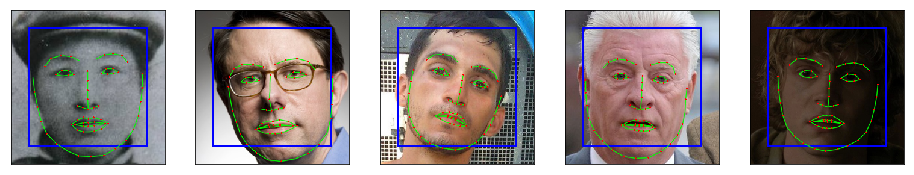

happy


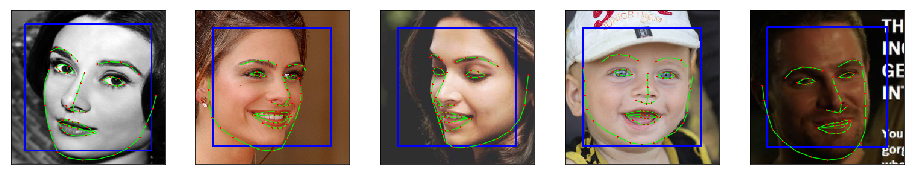

sad


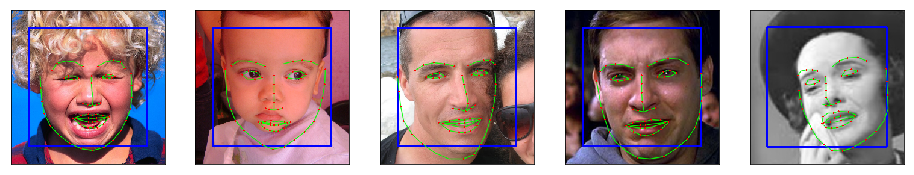

surprise


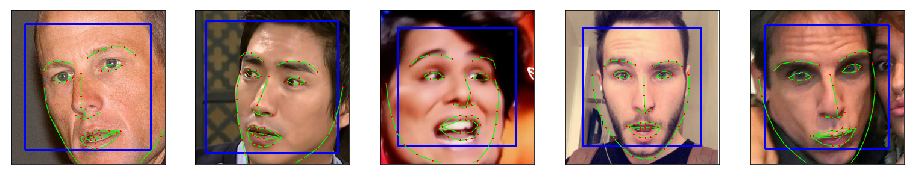

fear


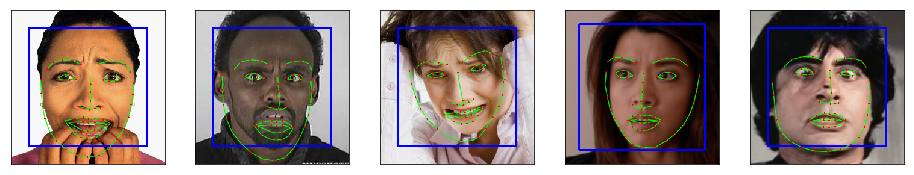

disgust


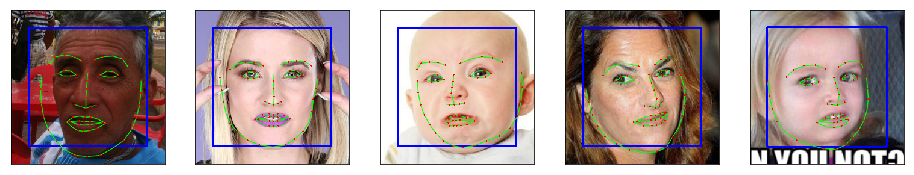

anger


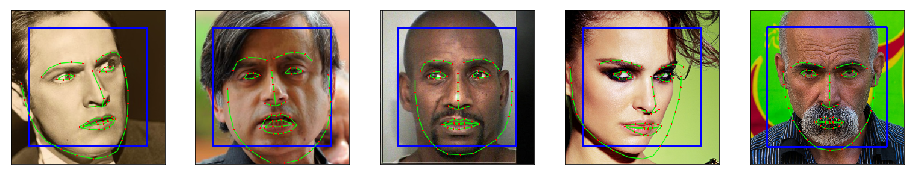

contempt


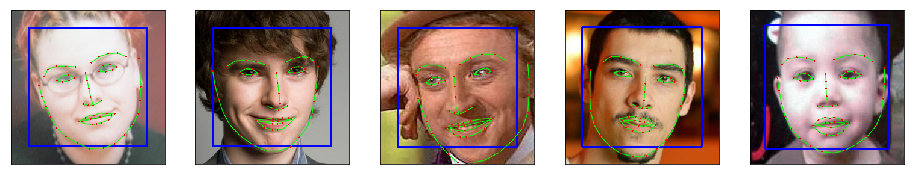

none


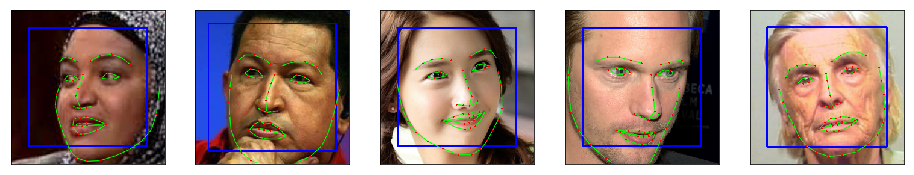

uncertain


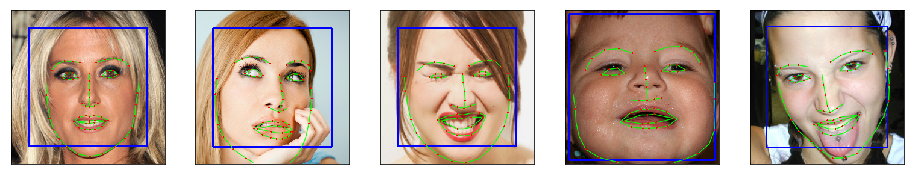

non-face


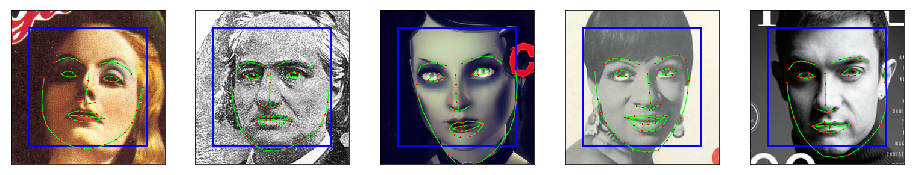

In [121]:
# Show some images in the training set
%matplotlib inline


import cv2
import matplotlib
import matplotlib.pyplot as plt
import sys
sys.path.append('D:\\hhj\\dlib_and_chehra_stuff')    # You'll need to change this
import ibug_face_tracker


# Get expression names
label_classes = {}
label_classes_path = os.path.join(os.getcwd(), 'expression_classes.csv')
with open(label_classes_path, 'r') as label_classes_file:
    label_classes_file.readline()
    while True:
        line = label_classes_file.readline().replace('\n', '').replace('\r', '')
        if len(line) == 0:
            break
        else:
            fields = line.split(',')
            label_classes[int(fields[0])] = fields[1]

# Get 5 random samples from each category and render everything
matplotlib.rcParams['figure.figsize'] = [16, 16]
for label_idx, expression in enumerate(all_expressions):
    samples = training_labels.loc[training_labels['expression'] == expression].sample(5)
    for idx in range(len(samples)):
        image_path = os.path.realpath(os.path.join(data_folder, samples.iloc[idx]['image_path']))
        landmarks = samples.iloc[idx]['landmarks']
        face_box = samples.iloc[idx]['face_box']
        image = cv2.imread(image_path)
        image_dimension = max(image.shape[0], image.shape[1])
        scale = 256.0 / image_dimension
        image = cv2.resize(image, (int(scale * image.shape[1]), int(scale * image.shape[0])))
        landmarks = landmarks * scale
        top_left = (int(face_box[0] * scale), int(face_box[1] * scale))
        bottom_right = (int((face_box[0] + face_box[2]) * scale), int((face_box[1] + face_box[3]) * scale))
        cv2.rectangle(image, top_left, bottom_right, (255, 0, 0), 2)
        ibug_face_tracker.FaceTracker.plot_landmark_connections(image, landmarks)
        ibug_face_tracker.FaceTracker.plot_facial_landmarks(image, landmarks)
        ax = plt.subplot(1, len(samples), idx + 1)
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_RGB2BGR))
        ax.set_xticks([])
        ax.set_yticks([])
    print(label_classes[label_idx])
    plt.show()

In [122]:
samples

,arousal,expression,face_box,image_path,landmarks,valence
241438,-2.0,10,"(55, 55, 371, 371)",1001/f2a89cbec9289b39869af93e7c76a194ec883bc2d...,"[[103.68, 211.76], [98.28, 247.35], [97.0, 284...",10.0
54608,-2.0,10,"(61, 61, 408, 408)",1017/a6611786425bed0abd0babeab894aa4f35c9c47e4...,"[[124.53, 239.93], [126.75, 280.92], [131.9, 3...",10.0
106781,-2.0,10,"(56, 56, 377, 377)",265/6eb27227de00cceb5306adaabc2b82d6bc1998884c...,"[[117.55, 235.07], [121.53, 274.63], [133.29, ...",10.0
289999,-2.0,10,"(21, 21, 141, 141)",985/3c9d07d5a68cc5d04dfaf92b3e22eb1e37559aa971...,"[[35.4, 72.07], [36.53, 89.33], [38.96, 106.25...",10.0
72584,-2.0,10,"(28, 28, 191, 191)",946/03db866110519b026855c2b603299a2fb87cabc9ea...,"[[59.19, 116.1], [61.18, 134.92], [64.89, 154....",10.0
